<a href="https://colab.research.google.com/github/TekyaygilFethi/BankMarketingAnalysis/blob/main/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
os.system("rm -rf Plots")
!mkdir Plots

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip3 install fpdf

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm
# from fpdf import FPDF

# Sales Revenues Read

In [ ]:
sales_revenues_df = pd.read_excel(open('Project_Dataset.xlsx', 'rb'),
              sheet_name='Sales_Revenues') 

In [ ]:
client_ids = sales_revenues_df["Client"]
client_ids

0      1094
1      1484
2        20
3      1193
4       142
       ... 
964    1316
965     905
966     938
967     434
968    1596
Name: Client, Length: 969, dtype: int64

# Social Dem Read

In [ ]:
soc_dem_df = pd.read_excel(open('Project_Dataset.xlsx', 'rb'),
              sheet_name='Soc_Dem') 

In [ ]:
filtered_soc_dem_df = soc_dem_df[soc_dem_df["Client"].isin(client_ids)]

In [ ]:
filtered_soc_dem_df

,Client,Sex,Age,Tenure
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106
5,225,M,14,187
...,...,...,...,...
1607,621,F,37,152
1609,1276,M,28,145
1611,384,M,23,160
1612,977,M,46,59


In [ ]:
filtered_soc_dem_df.isnull().sum()

Client    0
Sex       2
Age       0
Tenure    0
dtype: int64

In [ ]:
filtered_soc_dem_df['Sex'].mode()[0]

'M'

In [ ]:
filtered_soc_dem_df['Sex'].fillna(filtered_soc_dem_df['Sex'].mode()[0], inplace=True)

In [ ]:
filtered_soc_dem_df.isnull().sum()

Client    0
Sex       0
Age       0
Tenure    0
dtype: int64

In [ ]:
filtered_soc_dem_df.loc[filtered_soc_dem_df["Age"] < 18, "Age"] = 18

# Products ActBalance Read & Preprocessing

In [ ]:
products_actbalance_df = pd.read_excel(open('Project_Dataset.xlsx', 'rb'),
              sheet_name='Products_ActBalance') 

In [ ]:
filtered_products_actbalance_df = products_actbalance_df[products_actbalance_df["Client"].isin(client_ids)]

In [ ]:
filtered_products_actbalance_df

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.000000,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
5,6,1,NaN,NaN,NaN,NaN,1.0,4.297143,NaN,NaN,NaN,NaN,1982.071071
7,8,1,NaN,NaN,1.0,NaN,NaN,0.000000,NaN,NaN,326.969286,NaN,NaN
12,13,1,1.0,NaN,NaN,NaN,1.0,353.839643,5.832500,NaN,NaN,NaN,3458.295714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,1607,1,NaN,NaN,NaN,NaN,1.0,22887.368929,NaN,NaN,NaN,NaN,744.808214
1607,1608,1,NaN,NaN,NaN,1.0,1.0,554.165714,NaN,NaN,NaN,1.785714,3728.290714
1611,1612,1,NaN,NaN,1.0,NaN,1.0,170.593214,NaN,NaN,0.000000,NaN,6250.000000
1612,1613,1,NaN,NaN,NaN,NaN,NaN,676.008571,NaN,NaN,NaN,NaN,NaN


## Fill na values

In [ ]:
filtered_products_actbalance_df.isnull().sum()

Client          0
Count_CA        0
Count_SA      704
Count_MF      785
Count_OVD     718
Count_CC      859
Count_CL      890
ActBal_CA       0
ActBal_SA     704
ActBal_MF     785
ActBal_OVD    718
ActBal_CC     859
ActBal_CL     890
dtype: int64

In [ ]:
filtered_products_actbalance_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Client,969.0,814.781218,464.568139,1.000000,422.000000,819.000000,1216.000000,1615.000000
Count_CA,969.0,1.075335,0.323815,1.000000,1.000000,1.000000,1.000000,4.000000
Count_SA,265.0,1.181132,0.457702,1.000000,1.000000,1.000000,1.000000,3.000000
Count_MF,184.0,5.179348,9.354897,1.000000,1.000000,2.000000,5.000000,79.000000
Count_OVD,251.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CC,110.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CL,79.0,1.113924,0.319749,1.000000,1.000000,1.000000,1.000000,2.000000
ActBal_CA,969.0,2493.026329,6268.027982,0.000000,73.135000,536.951429,2262.178929,74934.956071
ActBal_SA,265.0,14427.773550,32615.370810,0.000000,725.631429,4352.067857,13326.190357,389883.830714
ActBal_MF,184.0,21250.471671,77683.063992,0.000000,0.000000,1953.776429,11241.016339,761235.504286


In [ ]:
filtered_products_actbalance_df.fillna(0, inplace=True)

In [ ]:
filtered_products_actbalance_df

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.0,0.000000,0.000000,0.000000
1,2,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.0,0.000000,0.000000,0.000000
5,6,1,0.0,0.0,0.0,0.0,1.0,4.297143,0.000000,0.0,0.000000,0.000000,1982.071071
7,8,1,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,326.969286,0.000000,0.000000
12,13,1,1.0,0.0,0.0,0.0,1.0,353.839643,5.832500,0.0,0.000000,0.000000,3458.295714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,1607,1,0.0,0.0,0.0,0.0,1.0,22887.368929,0.000000,0.0,0.000000,0.000000,744.808214
1607,1608,1,0.0,0.0,0.0,1.0,1.0,554.165714,0.000000,0.0,0.000000,1.785714,3728.290714
1611,1612,1,0.0,0.0,1.0,0.0,1.0,170.593214,0.000000,0.0,0.000000,0.000000,6250.000000
1612,1613,1,0.0,0.0,0.0,0.0,0.0,676.008571,0.000000,0.0,0.000000,0.000000,0.000000


In [ ]:
filtered_products_actbalance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      969 non-null    int64  
 1   Count_CA    969 non-null    int64  
 2   Count_SA    969 non-null    float64
 3   Count_MF    969 non-null    float64
 4   Count_OVD   969 non-null    float64
 5   Count_CC    969 non-null    float64
 6   Count_CL    969 non-null    float64
 7   ActBal_CA   969 non-null    float64
 8   ActBal_SA   969 non-null    float64
 9   ActBal_MF   969 non-null    float64
 10  ActBal_OVD  969 non-null    float64
 11  ActBal_CC   969 non-null    float64
 12  ActBal_CL   969 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 106.0 KB


## Column type conversions

In [ ]:
to_be_converted_column = filtered_products_actbalance_df.columns[2:7]

In [ ]:
to_be_converted_column

Index(['Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL'], dtype='object')

In [ ]:
for col in to_be_converted_column:
  filtered_products_actbalance_df[col] = filtered_products_actbalance_df[col].astype("int64")

In [ ]:
filtered_products_actbalance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      969 non-null    int64  
 1   Count_CA    969 non-null    int64  
 2   Count_SA    969 non-null    int64  
 3   Count_MF    969 non-null    int64  
 4   Count_OVD   969 non-null    int64  
 5   Count_CC    969 non-null    int64  
 6   Count_CL    969 non-null    int64  
 7   ActBal_CA   969 non-null    float64
 8   ActBal_SA   969 non-null    float64
 9   ActBal_MF   969 non-null    float64
 10  ActBal_OVD  969 non-null    float64
 11  ActBal_CC   969 non-null    float64
 12  ActBal_CL   969 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 106.0 KB


In [ ]:
filtered_products_actbalance_df

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,0,0,1,0,0,1333.802857,0.000000,0.0,0.000000,0.000000,0.000000
1,2,1,1,0,0,0,0,110.768571,13326.190357,0.0,0.000000,0.000000,0.000000
5,6,1,0,0,0,0,1,4.297143,0.000000,0.0,0.000000,0.000000,1982.071071
7,8,1,0,0,1,0,0,0.000000,0.000000,0.0,326.969286,0.000000,0.000000
12,13,1,1,0,0,0,1,353.839643,5.832500,0.0,0.000000,0.000000,3458.295714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,1607,1,0,0,0,0,1,22887.368929,0.000000,0.0,0.000000,0.000000,744.808214
1607,1608,1,0,0,0,1,1,554.165714,0.000000,0.0,0.000000,1.785714,3728.290714
1611,1612,1,0,0,1,0,1,170.593214,0.000000,0.0,0.000000,0.000000,6250.000000
1612,1613,1,0,0,0,0,0,676.008571,0.000000,0.0,0.000000,0.000000,0.000000


# Inflow Outflow Read & Preprocessing

In [ ]:
inflow_outflow_df = pd.read_excel(open('Project_Dataset.xlsx', 'rb'),
              sheet_name='Inflow_Outflow') 

In [ ]:
inflow_outflow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1587 non-null   int64  
 1   VolumeCred                    1587 non-null   float64
 2   VolumeCred_CA                 1587 non-null   float64
 3   TransactionsCred              1587 non-null   int64  
 4   TransactionsCred_CA           1587 non-null   int64  
 5   VolumeDeb                     1587 non-null   float64
 6   VolumeDeb_CA                  1587 non-null   float64
 7   VolumeDebCash_Card            1587 non-null   float64
 8   VolumeDebCashless_Card        1587 non-null   float64
 9   VolumeDeb_PaymentOrder        1587 non-null   float64
 10  TransactionsDeb               1587 non-null   int64  
 11  TransactionsDeb_CA            1587 non-null   int64  
 12  TransactionsDebCash_Card      1587 non-null   int64  
 13  Tra

In [ ]:
inflow_outflow_df.isnull().sum()

Client                          0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDeb_PaymentOrder    0
dtype: int64

In [ ]:
inflow_outflow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Client,1587.0,808.174543,466.744374,1.0,405.500000,808.000000,1213.500000,1615.000000
VolumeCred,1587.0,1823.559572,5864.792552,0.0,252.923393,655.867500,1426.027143,107703.804286
VolumeCred_CA,1587.0,1506.329113,4661.535696,0.0,214.290893,620.858214,1304.757143,98717.675000
TransactionsCred,1587.0,5.541903,6.355383,0.0,2.000000,3.000000,6.000000,63.000000
TransactionsCred_CA,1587.0,4.265280,4.944032,0.0,2.000000,3.000000,4.000000,48.000000
VolumeDeb,1587.0,1697.218658,5183.787844,0.0,226.214286,654.615357,1418.208214,119906.503929
VolumeDeb_CA,1587.0,1460.202903,4281.369956,0.0,211.848750,632.148929,1329.007857,73477.932500
VolumeDebCash_Card,1587.0,257.937337,757.734230,0.0,0.000000,71.428571,353.370536,23571.428571
VolumeDebCashless_Card,1587.0,150.850401,311.938796,0.0,0.000000,20.139286,175.892500,3637.616786
VolumeDeb_PaymentOrder,1587.0,715.974931,3215.106760,0.0,0.000000,175.428571,507.607143,72278.782143


In [ ]:
checked_columns = inflow_outflow_df.select_dtypes(include=["int64","float64"]).columns[1:]

In [ ]:
checked_columns

Index(['VolumeCred', 'VolumeCred_CA', 'TransactionsCred',
       'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
      dtype='object')

## Z-score Evaluation

In [ ]:
from scipy import stats

In [ ]:
for col in checked_columns:
  inflow_outflow_df[col+"zscore"] = abs(stats.zscore(inflow_outflow_df[col].values, axis = 0))
  inflow_outflow_df.loc[inflow_outflow_df[col+"zscore"] > 3, col] = inflow_outflow_df.loc[inflow_outflow_df[col+"zscore"] <= 3][col].mean()
  inflow_outflow_df.drop(col+"zscore", axis = 1, inplace=True)

In [ ]:
inflow_outflow_df

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1.0,1.0,118.046429,118.046429,25.000000,91.796429,0.000000,12.0,12.0,2.0,9.0,0.0
1,1456,364.772143,364.752857,4.0,3.0,774.980000,774.980000,14.285714,497.444286,258.607143,28.0,28.0,1.0,20.0,5.0
2,545,2471.719286,2471.719286,14.0,14.0,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23.0,23.0,3.0,5.0,12.0
3,667,1127.792857,1127.792857,4.0,4.0,1344.603571,1344.603571,642.857143,194.285714,249.321429,21.0,21.0,3.0,4.0,8.0
4,1381,571.618214,571.618214,3.0,3.0,57.071429,57.071429,10.714286,46.357143,0.000000,6.0,6.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,108,1175.480357,1171.326071,8.0,6.0,465.500000,465.500000,0.000000,31.607143,430.500000,10.0,10.0,0.0,2.0,7.0
1583,1079,281.812857,281.812857,2.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1584,1126,283.104643,283.104643,2.0,2.0,40.285714,40.285714,0.000000,0.000000,39.285714,2.0,2.0,0.0,0.0,1.0
1585,134,528.711071,433.429286,3.0,2.0,403.821429,401.000000,285.714286,0.000000,0.000000,6.0,5.0,2.0,0.0,0.0


# Merge Dataframes

In [ ]:
dfm1 = pd.merge(filtered_soc_dem_df, filtered_products_actbalance_df, on ="Client")

In [ ]:
dfm2 = pd.merge(dfm1, inflow_outflow_df, on ="Client")

In [ ]:
dfm2["IsFemale"] = (dfm2["Sex"] == "F").astype("int64")
dfm2.drop("Sex", inplace=True,axis =1)

In [ ]:
dfm2.head()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,IsFemale
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,714.285714,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0,0
1,850,49,44,1,0,0,0,0,0,43.523214,...,1226.345357,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0,1
2,1473,54,34,1,1,0,0,1,1,29.024286,...,3794.580714,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0,0
3,1038,29,106,1,0,0,0,0,0,27.035714,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,225,18,187,1,0,0,1,0,0,345.686071,...,130.521429,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0,0


In [ ]:
dfm2.shape

(951, 30)

# Sales Revenues Read (Label Reads)

In [ ]:
sales_revenues_label_df = pd.read_excel(open('Project_Dataset.xlsx', 'rb'),
              sheet_name='Sales_Revenues')

In [ ]:
sales_revenues_label_df.shape

(969, 7)

In [ ]:
sales_revenues_label_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


In [ ]:
sales_revenues_label_df["Sale_MF"].unique()

array([0, 1])

In [ ]:
sales_revenues_label_df["Sale_CC"].unique()

array([1, 0])

In [ ]:
sales_revenues_label_df["Sale_CL"].unique()

array([0, 1])

# Model Creation, Training & Prediction

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
from tensorflow import keras

## Sci-kit Learn Models (For Linear Regression)

In [ ]:
def CreateGridSearchParams():
  lin_model_params = {}
  lasso_model_params = {"alpha": np.arange(0.1,1.0,0.1)},
  ridge_model_params = {"alpha": np.arange(0.1,1.0,0.1)},
  sgd_model_params = {"loss": ["huber","squared_error","epsilon_insensitive","squared_epsilon_insensitive"], "penalty":["l2","l1","elasticnet"],"learning_rate":["constant","optimal","invscaling","adaptive"]}
  svr_model_params = {"C":np.arange(0.5,1.5,0.1), "epsilon":np.arange(0.1,1.0,0.1)}

  return [lin_model_params, lasso_model_params, ridge_model_params, sgd_model_params, svr_model_params]

In [ ]:
def InstantiateModels(name, args):
  if name == "Linear Model":
    return LinearRegression(**args)
  if name == "Lasso Model":
    return Lasso(**args)
  if name == "Ridge Model":
    return Ridge(**args)
  if name == "SGD Model":
    return SGDRegressor(**args)
  if name == "SVR Model":
    return SVR(**args)

In [ ]:
def GetBestLinearModel(df, col_name_reg):
  X = df.iloc[:,1:-2]
  y = df.iloc[:,-1]
  
  models = [["Linear Model",LinearRegression()], ["Lasso Model", Lasso()], ["Ridge Model",Ridge()], ["SGD Model",SGDRegressor()],["SVR Model",SVR()]]
  params = CreateGridSearchParams()
  scores = []

  for idx, model_tuple in enumerate(models):
    m = GridSearchCV(model_tuple[1], params[idx]).fit(X,y)
    m = InstantiateModels(model_tuple[0], m.best_params_).fit(X,y)
    scores.append(m.score(X,y))
    models[idx][1] = m
    
  best_score_idx = np.argmax(scores)
  print(f"{models[best_score_idx][0]} has the best score for column {col_name_reg}! Best Score is: {scores[best_score_idx]}")
  best_model = models[best_score_idx][1]

  return (X, y, best_model)

In [ ]:
def GetPreprocessedDFForLinearPrediction(dfm2_new, y_tf_predictions, col_name_cls, col_name_reg):
  dfm2_new["Predicted_"+col_name_cls] = y_tf_predictions

  if col_name_cls == "Sale_CL":
    dfm2_new.loc[dfm2_new["Age"] > 65, "Predicted_Sale_CL"] = 0
  
  dfm2_new_predicted_true = dfm2_new[dfm2_new["Predicted_"+col_name_cls] == 1]
  df = pd.merge(dfm2_new_predicted_true, sales_revenues_label_df[["Client", col_name_reg]], on ="Client")

  return df

In [ ]:
def PredictLinearModel(model, lin_df, X, col_name_reg):
  return model.predict(X)

In [ ]:
def PreprocessLinearDF(lin_df, col_name_reg, predict):
  lin_df["Predicted_"+col_name_reg] = predict

  lin_df["Predicted_"+col_name_reg] = np.array(map(lambda x: x if x>=0 else np.nan, lin_df["Predicted_"+col_name_reg].values))
  lin_df = lin_df.fillna(0)
  lin_df.drop(col_name_reg, inplace=True, axis = 1)
  return lin_df

## TensorFlow model (For Logistic Regression)

In [ ]:
from keras import backend as K

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def CreateLogisticNeuralModel():
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(32, input_dim = 29, activation='relu'))
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall_m, precision_m, f1_m])

  return model

In [ ]:
def TrainLogisticNeuralModel(X_train, y_train, model):
  history = model.fit(X_train, y_train, epochs=25, verbose = 0)

  return (history, model)

In [ ]:
def PredictLogisticNeuralNetwork(X, tf_model):
  y_tf_predictions = tf_model.predict(X)
  y_tf_predictions = y_tf_predictions >= 0.5
  y_tf_predictions= y_tf_predictions.astype(int)

  return y_tf_predictions

In [ ]:
def MetricsForModel(model, X_test, y_test, col_name_cls):
  loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
  print(f"Metrics for {col_name_cls}:\n\nLoss: {loss}\nAccuracy: {accuracy}\nF1 Score: {f1_score}\nPrecision: {precision}\nRecall: {recall}\n")

In [ ]:
from sklearn.metrics import confusion_matrix

def ConfusionMatrixPlot(y_true, y_pred, col_name_cls):
  sns.heatmap(confusion_matrix(y_pred, y_true), annot=True, fmt='g')
  plt.title(col_name_cls)
  plt.savefig(f"Plots/{col_name_cls}_Confusion_Matrix.png")
  plt.show()

## Common Predictor For Unseen Data

In [ ]:
def PredictAccordingToTheGivenColumns(col_name_cls, col_name_reg):
  print(f"{col_name_cls} - {col_name_reg}")
  merged_df = pd.merge(dfm2, sales_revenues_label_df[["Client", col_name_cls]], on ="Client")

  X = merged_df.iloc[:,1:-1]
  y = merged_df.iloc[:,-1]

  tf_model = CreateLogisticNeuralModel()
  history, tf_model = TrainLogisticNeuralModel(X, y, tf_model)
  tf_model_prediction = PredictLogisticNeuralNetwork(X, tf_model)
  MetricsForModel(tf_model, X, y, col_name_cls)
  ConfusionMatrixPlot(y, tf_model_prediction, col_name_cls)
  # Create, train and predict Linear model
  lin_df = GetPreprocessedDFForLinearPrediction(dfm2.copy(), tf_model_prediction, col_name_cls, col_name_reg)
  X, y, best_model = GetBestLinearModel(lin_df, col_name_reg)
  lin_model_prediction = PredictLinearModel(best_model, lin_df, X, col_name_reg)
  lin_df = PreprocessLinearDF(lin_df, col_name_reg, lin_model_prediction)
  
  return lin_df

# Prediction

In [ ]:
sale_mf_df = PredictAccordingToTheGivenColumns("Sale_MF", "Revenue_MF")

In [ ]:
sale_cc_df = PredictAccordingToTheGivenColumns("Sale_CC", "Revenue_CC")

In [ ]:
sale_cl_df = PredictAccordingToTheGivenColumns("Sale_CL", "Revenue_CL")

In [ ]:
sale_mf_df.head()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,IsFemale,Predicted_Sale_MF,Predicted_Revenue_MF
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0,0,1,2.980317
1,1219,33,19,1,0,0,0,0,0,5164.206429,...,19.671429,246.321429,13.0,13.0,2.0,3.0,5.0,0,1,0.000000
2,1574,30,149,1,0,0,0,0,0,478.543571,...,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,1,1,0.534842
3,36,49,263,1,1,2,0,0,0,60.997857,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,35.246609
4,390,50,67,1,1,79,0,0,0,442.346071,...,213.951786,397.142857,38.0,38.0,2.0,29.0,6.0,0,1,2.178929


In [ ]:
sale_cc_df

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,IsFemale,Predicted_Sale_CC,Predicted_Revenue_CC
0,739,69,55,1,1,8,1,0,1,5519.308929,...,211.182143,0.000000,7.0,5.000000,0.0,3.0,0.000000,0,1,1.580914
1,137,63,168,3,0,1,0,0,0,185.722143,...,255.909286,67.428571,11.0,11.000000,1.0,6.0,3.000000,1,1,1.474218
2,1048,65,71,1,0,0,1,0,0,1911.491429,...,0.000000,0.000000,3.0,3.000000,1.0,0.0,0.000000,1,1,1.760046
3,123,22,40,2,0,0,0,0,0,8883.968214,...,33.928571,0.000000,2.0,2.000000,0.0,1.0,0.000000,1,1,0.471939
4,1160,19,260,1,0,0,1,0,1,2723.980357,...,190.814286,178.642857,28.0,26.000000,3.0,9.0,7.000000,0,1,8.819955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,694,34,40,1,1,0,0,0,1,0.002143,...,182.000000,16.964286,12.0,12.000000,4.0,3.0,1.000000,1,1,0.000000
250,408,35,181,1,1,0,1,0,0,4133.402143,...,120.737412,431.522263,54.0,12.654685,2.0,19.0,4.310742,0,1,37.698306
251,1367,38,18,1,1,0,0,0,0,0.000000,...,35.357143,721.678571,18.0,18.000000,5.0,1.0,11.000000,1,1,0.000000
252,963,71,104,1,1,1,0,0,0,10607.822857,...,0.000000,438.642857,7.0,7.000000,0.0,0.0,6.000000,1,1,9.473119


In [ ]:
sale_cl_df 

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,IsFemale,Predicted_Sale_CL,Predicted_Revenue_CL
0,1473,54,34,1,1,0,0,1,1,29.024286,...,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0,0,1,0.000000
1,225,18,187,1,0,0,1,0,0,345.686071,...,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0,0,1,9.240622
2,1231,18,232,1,0,0,0,0,0,819.853929,...,0.000000,0.000000,9.0,9.0,6.0,0.0,0.0,1,1,7.658708
3,956,52,139,2,0,0,1,0,0,3611.397857,...,118.721071,624.214286,27.0,20.0,1.0,4.0,11.0,0,1,8.211200
4,137,63,168,3,0,1,0,0,0,185.722143,...,255.909286,67.428571,11.0,11.0,1.0,6.0,3.0,1,1,4.663288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,809,30,157,1,0,0,0,0,1,16.623929,...,372.268214,44.642857,30.0,28.0,3.0,20.0,2.0,0,1,3.105693
259,1012,23,99,1,0,0,0,0,0,2.737500,...,0.000000,221.607143,5.0,5.0,1.0,0.0,3.0,1,1,3.129383
260,1171,27,119,1,0,0,0,0,0,5.632500,...,238.892857,121.785714,10.0,10.0,2.0,3.0,4.0,1,1,4.173448
261,573,56,77,1,0,0,0,0,0,1243.505714,...,114.962500,228.250000,14.0,14.0,3.0,4.0,4.0,1,1,0.823783


In [ ]:
# Here we should not give Customer Loan to the people who are older than 65.
sale_cl_df[sale_cl_df["Age"] > 65]["Predicted_Sale_CL"]

Series([], Name: Predicted_Sale_CL, dtype: int64)

In [ ]:
truth_values_merged_df = pd.merge(dfm2, sales_revenues_label_df, on ="Client")

In [ ]:
sale_mf_df[["Client", "Predicted_Sale_MF", "Predicted_Revenue_MF"]]

,Client,Predicted_Sale_MF,Predicted_Revenue_MF
0,1217,1,2.980317
1,1219,1,0.000000
2,1574,1,0.534842
3,36,1,35.246609
4,390,1,2.178929
...,...,...,...
199,424,1,0.000000
200,1282,1,0.000000
201,621,1,3.777615
202,384,1,0.000000


In [ ]:
truth_values_merged_df

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,IsFemale,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,0.0,0.0,1.0,0,0,0,0,0.000000,0.000000,0.000000
1,850,49,44,1,0,0,0,0,0,43.523214,...,0.0,0.0,1.0,1,0,1,0,0.000000,0.893929,0.000000
2,1473,54,34,1,1,0,0,1,1,29.024286,...,1.0,26.0,11.0,0,1,0,0,4.929643,0.000000,0.000000
3,1038,29,106,1,0,0,0,0,0,27.035714,...,0.0,0.0,0.0,0,0,0,0,0.000000,0.000000,0.000000
4,225,18,187,1,0,0,1,0,0,345.686071,...,0.0,4.0,1.0,0,0,0,1,0.000000,0.000000,8.130714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,37,152,1,1,0,0,0,0,1249.709643,...,0.0,0.0,0.0,1,0,0,0,0.000000,0.000000,0.000000
947,1276,28,145,1,0,0,0,0,2,13915.925357,...,1.0,0.0,0.0,0,0,0,0,0.000000,0.000000,0.000000
948,384,23,160,1,0,0,0,0,0,2418.876786,...,2.0,5.0,1.0,0,0,1,1,0.000000,6.107143,12.506071
949,977,46,59,1,0,0,0,0,0,2639.308571,...,2.0,1.0,1.0,0,1,0,0,1.429643,0.000000,0.000000


In [ ]:
merged_df_1 = pd.merge(truth_values_merged_df ,sale_mf_df[["Client", "Predicted_Sale_MF", "Predicted_Revenue_MF"]], on="Client", how="left")

In [ ]:
merged_df_2 = pd.merge(merged_df_1 ,sale_cc_df[["Client", "Predicted_Sale_CC", "Predicted_Revenue_CC"]], on="Client", how="left")

In [ ]:
final_merged_df = pd.merge(merged_df_2 ,sale_cl_df[["Client", "Predicted_Sale_CL", "Predicted_Revenue_CL"]], on="Client", how="left")

In [ ]:
final_merged_df = final_merged_df.fillna(0)

In [ ]:
final_merged_df.head()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Predicted_Sale_MF,Predicted_Revenue_MF,Predicted_Sale_CC,Predicted_Revenue_CC,Predicted_Sale_CL,Predicted_Revenue_CL
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,0,0.000000,0.000000,0.000000,1.0,2.980317,0.0,0.0,0.0,0.000000
1,850,49,44,1,0,0,0,0,0,43.523214,...,0,0.000000,0.893929,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,1473,54,34,1,1,0,0,1,1,29.024286,...,0,4.929643,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.000000
3,1038,29,106,1,0,0,0,0,0,27.035714,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
4,225,18,187,1,0,0,1,0,0,345.686071,...,1,0.000000,0.000000,8.130714,0.0,0.000000,0.0,0.0,1.0,9.240622


In [ ]:
final_merged_df[final_merged_df["Age"]>65]["Predicted_Sale_CL"]

7      0.0
30     0.0
31     0.0
43     0.0
54     0.0
      ... 
907    0.0
908    0.0
913    0.0
927    0.0
929    0.0
Name: Predicted_Sale_CL, Length: 137, dtype: float64

In [ ]:
final_merged_df.columns[:-6]

Index(['Client', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'IsFemale', 'Sale_MF', 'Sale_CC',
       'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'],
      dtype='object')

In [ ]:
filter_cols = list(final_merged_df.columns[:-6])
filter_cols.extend(["Predicted_Sale_MF","Predicted_Sale_CC","Predicted_Sale_CL","Predicted_Revenue_MF","Predicted_Revenue_CC","Predicted_Revenue_CL"])

In [ ]:
final_merged_df = final_merged_df[filter_cols]

In [ ]:
final_merged_df.head()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Predicted_Sale_MF,Predicted_Sale_CC,Predicted_Sale_CL,Predicted_Revenue_MF,Predicted_Revenue_CC,Predicted_Revenue_CL
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,0,0.000000,0.000000,0.000000,1.0,0.0,0.0,2.980317,0.0,0.000000
1,850,49,44,1,0,0,0,0,0,43.523214,...,0,0.000000,0.893929,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,1473,54,34,1,1,0,0,1,1,29.024286,...,0,4.929643,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000
3,1038,29,106,1,0,0,0,0,0,27.035714,...,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,225,18,187,1,0,0,1,0,0,345.686071,...,1,0.000000,0.000000,8.130714,0.0,0.0,1.0,0.000000,0.0,9.240622


In [ ]:
final_merged_df # next step for visualization

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Predicted_Sale_MF,Predicted_Sale_CC,Predicted_Sale_CL,Predicted_Revenue_MF,Predicted_Revenue_CC,Predicted_Revenue_CL
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,0,0.000000,0.000000,0.000000,1.0,0.0,0.0,2.980317,0.0,0.000000
1,850,49,44,1,0,0,0,0,0,43.523214,...,0,0.000000,0.893929,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,1473,54,34,1,1,0,0,1,1,29.024286,...,0,4.929643,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000
3,1038,29,106,1,0,0,0,0,0,27.035714,...,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,225,18,187,1,0,0,1,0,0,345.686071,...,1,0.000000,0.000000,8.130714,0.0,0.0,1.0,0.000000,0.0,9.240622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,37,152,1,1,0,0,0,0,1249.709643,...,0,0.000000,0.000000,0.000000,1.0,0.0,0.0,3.777615,0.0,0.000000
947,1276,28,145,1,0,0,0,0,2,13915.925357,...,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
948,384,23,160,1,0,0,0,0,0,2418.876786,...,1,0.000000,6.107143,12.506071,1.0,0.0,0.0,0.000000,0.0,0.000000
949,977,46,59,1,0,0,0,0,0,2639.308571,...,0,1.429643,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000


# Visualization

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
d = {
    "Predicted_Sale_CL": len(final_merged_df[final_merged_df["Predicted_Sale_CL"] == 1.0]),
    "Predicted_Sale_CC": len(final_merged_df[final_merged_df["Predicted_Sale_CC"] == 1.0]),
    "Predicted_Sale_MF": len(final_merged_df[final_merged_df["Predicted_Sale_MF"] == 1.0])
}

In [ ]:
d

{'Predicted_Sale_CC': 254, 'Predicted_Sale_CL': 263, 'Predicted_Sale_MF': 204}

In [ ]:
sum(list(d.values()))

721

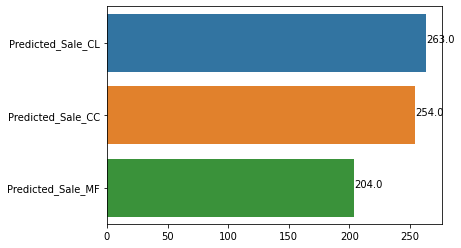

In [ ]:
pl = sns.barplot(x = list(d.values()), y = list(d.keys()))
show_values(pl, "h")
plt.savefig("Plots/Predicted_Products.png", bbox_inches='tight')

In [ ]:
def VisualizeDistribution(df, column_name, cor):
  sns.histplot(x=df[df[column_name] > 0][column_name], kde = True, ax=axes[cor,0])
  sns.kdeplot(x=df[df[column_name] > 0][column_name], ax=axes[cor,1])

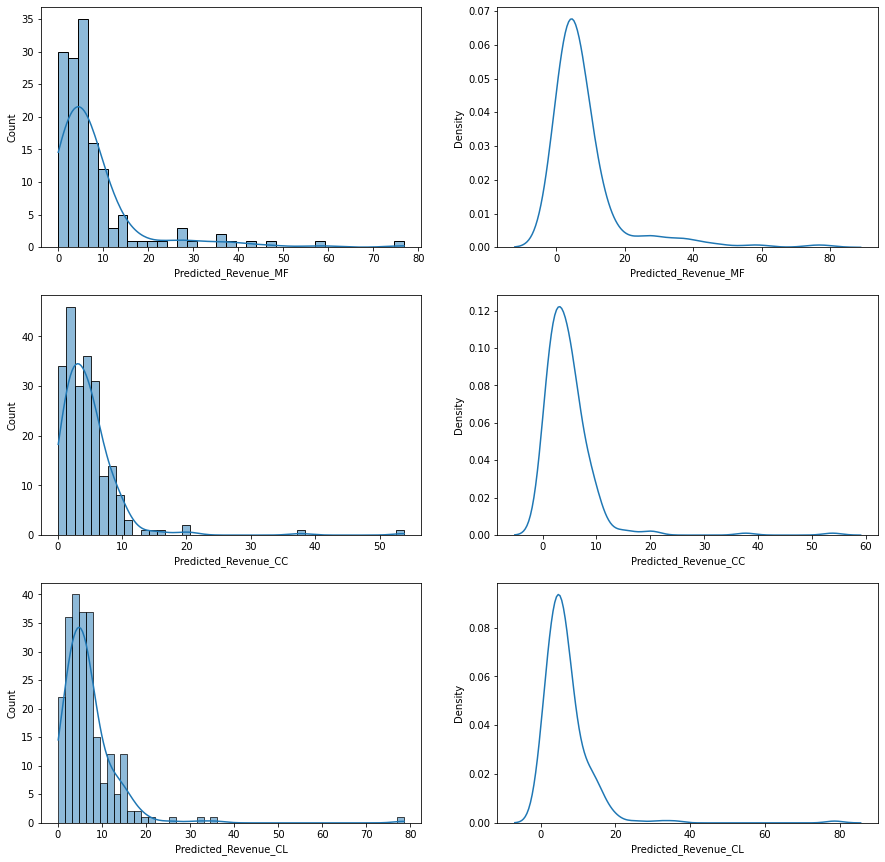

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (15,15))

VisualizeDistribution(final_merged_df, "Predicted_Revenue_MF", 0)
VisualizeDistribution(final_merged_df, "Predicted_Revenue_CC", 1)
VisualizeDistribution(final_merged_df, "Predicted_Revenue_CL", 2)

plt.savefig("Plots/Predicted_Products_Distribution.png")

In [ ]:
final_merged_df.columns

Index(['Client', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'IsFemale', 'Sale_MF', 'Sale_CC',
       'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL',
       'Predicted_Sale_MF', 'Predicted_Sale_CC', 'Predicted_Sale_CL',
       'Predicted_Revenue_MF', 'Predicted_Revenue_CC', 'Predicted_Revenue_CL'],
      dtype='object')

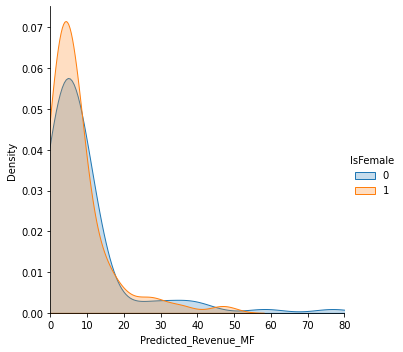

In [ ]:
(sns
 .FacetGrid(final_merged_df[final_merged_df["Predicted_Revenue_MF"] > 0],
            hue="IsFemale",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Predicted_Revenue_MF",shade=True)
 .add_legend())

plt.savefig("Plots/Sex_Distribution_Predicted_Revenue_MF.png")

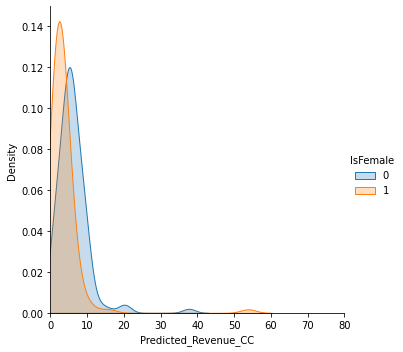

In [ ]:
(sns
 .FacetGrid(final_merged_df[final_merged_df["Predicted_Revenue_CC"] > 0],
            hue="IsFemale",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Predicted_Revenue_CC",shade=True)
 .add_legend())

plt.savefig("Plots/Sex_Distribution_Predicted_Revenue_CC.png")

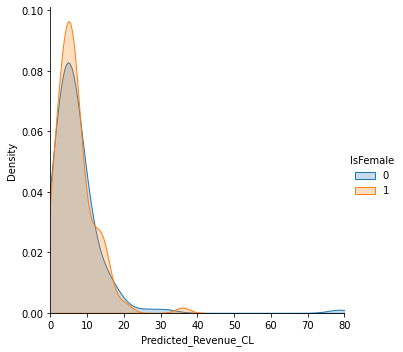

In [ ]:
(sns
 .FacetGrid(final_merged_df[final_merged_df["Predicted_Revenue_CL"] > 0],
            hue="IsFemale",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Predicted_Revenue_CL",shade=True)
 .add_legend())

plt.savefig("Plots/Sex_Distribution_Predicted_Revenue_CL.png")

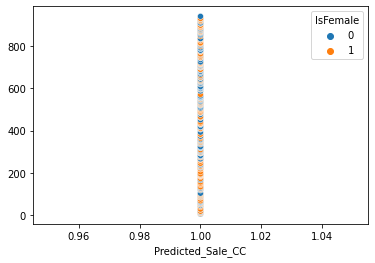

In [ ]:
sns.scatterplot(data = final_merged_df[final_merged_df["Predicted_Sale_CC"] == 1], x="Predicted_Sale_CC",y = final_merged_df[final_merged_df["Predicted_Sale_CC"] == 1].index, hue = "IsFemale")

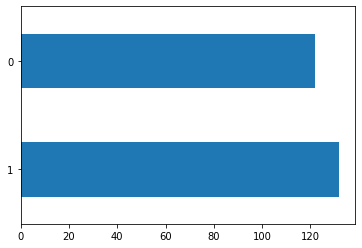

In [ ]:
final_merged_df[final_merged_df["Predicted_Sale_CC"] == 1]["IsFemale"].value_counts().plot.barh()

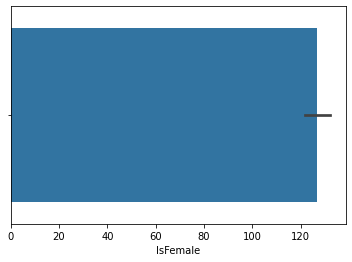

In [ ]:
sns.barplot(x = final_merged_df[final_merged_df["Predicted_Sale_CC"] == 1]["IsFemale"].value_counts())

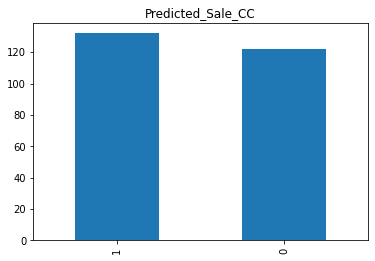

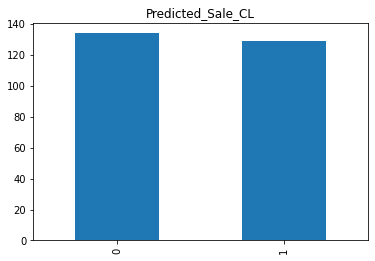

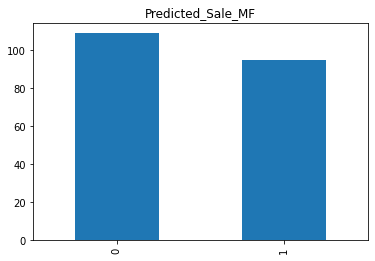

In [ ]:
#fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (15,15))
cols = ["CC","CL","MF"]
for col_value in cols:
  p = final_merged_df[final_merged_df["Predicted_Sale_"+col_value] == 1]["IsFemale"].value_counts().plot.bar(stacked=True)
  p.set_title("Predicted_Sale_"+col_value)
  plt.show()
  p.figure.savefig(f"Plots/Sex_Discrimination_Predicted_Sale_{col_value}.png")
  print()

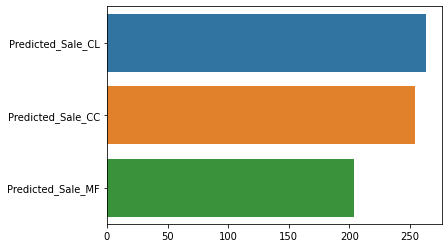

In [ ]:
sns.barplot(x = list(d.values()), y = list(d.keys()))


VisualizeDistribution(final_merged_df, "Predicted_Revenue_MF", 0)
VisualizeDistribution(final_merged_df, "Predicted_Revenue_CC", 1)
VisualizeDistribution(final_merged_df, "Predicted_Revenue_CL", 2)

In [ ]:
filtered_products_actbalance_df["Count_SA"].unique()

array([0, 1, 2, 3])

In [ ]:
filtered_products_actbalance_df["Count_SA"].value_counts()

0    704
1    225
2     32
3      8
Name: Count_SA, dtype: int64

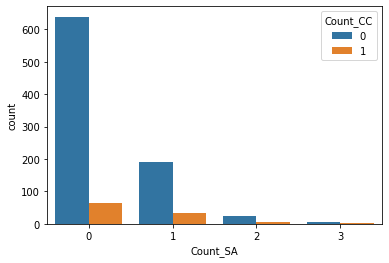

In [ ]:
sns.countplot(x = "Count_SA" ,data = filtered_products_actbalance_df, hue = "Count_CC")
plt.savefig("Plots/CC_SA_Relation.png")

In [ ]:
filtered_soc_dem_df = filtered_soc_dem_df = filtered_soc_dem_df[filtered_soc_dem_df["Client"].isin(client_ids)]

In [ ]:
filtered_soc_dem_df

,Client,Sex,Age,Tenure
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106
5,225,M,18,187
...,...,...,...,...
1607,621,F,37,152
1609,1276,M,28,145
1611,384,M,23,160
1612,977,M,46,59


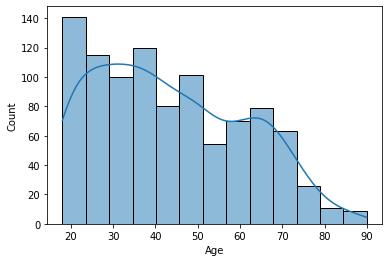

In [ ]:
sns.histplot(data = filtered_soc_dem_df["Age"], kde=True)
plt.savefig("Plots/Age_Distribution.png")

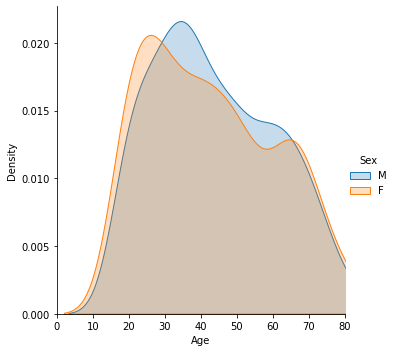

In [ ]:
(sns
 .FacetGrid(filtered_soc_dem_df,
            hue="Sex",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Age",shade=True)
 .add_legend())

plt.savefig("Plots/Sex_Discrimination_Of_Age_Distribution.png")

In [ ]:
# First merging
result_df = pd.merge(filtered_products_actbalance_df, filtered_soc_dem_df, on="Client")

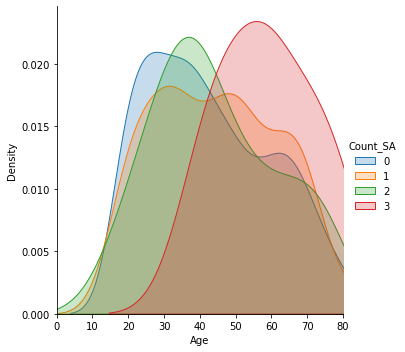

In [ ]:
(sns
 .FacetGrid(result_df,
            hue="Count_SA",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Age",shade=True)
 .add_legend())

plt.savefig("Plots/Count_SA_Discrimination_Of_Age_Distribution.png")

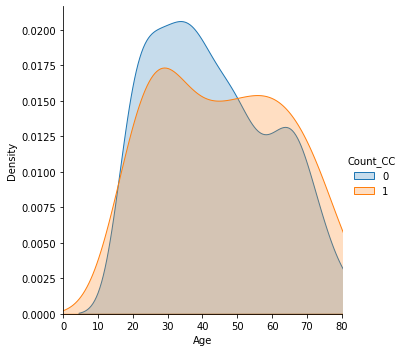

In [ ]:
(sns
 .FacetGrid(result_df,
            hue="Count_CC",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Age",shade=True)
 .add_legend())

plt.savefig("Plots/Count_CC_Discrimination_Of_Age_Distribution.png")

In [ ]:
result_df["Count_MF"].nunique()

26

In [ ]:
result_df["Count_MF"].unique()

array([ 0,  2,  4,  1,  3, 12,  5,  9,  6, 35,  7, 19, 25, 27, 10, 11, 13,
       79, 14, 64, 17, 20,  8, 18, 26, 45])

In [ ]:
result_df["Count_MF"].value_counts()

0     785
1      66
2      29
3      26
6      12
4      12
5       7
7       7
11      4
26      2
18      2
8       2
10      2
14      1
20      1
17      1
64      1
27      1
79      1
13      1
25      1
19      1
35      1
9       1
12      1
45      1
Name: Count_MF, dtype: int64

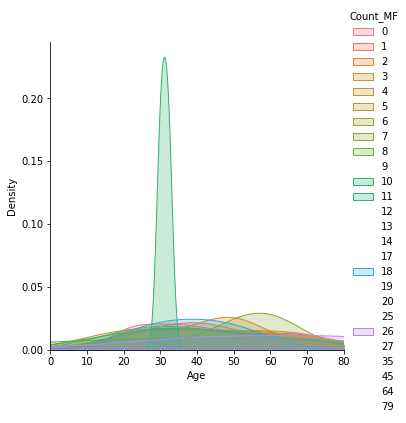

In [ ]:
(sns
 .FacetGrid(result_df,
            hue="Count_MF",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Age",shade=True)
 .add_legend())

plt.savefig("Plots/Count_MF_Discrimination_Of_Age_Distribution.png")

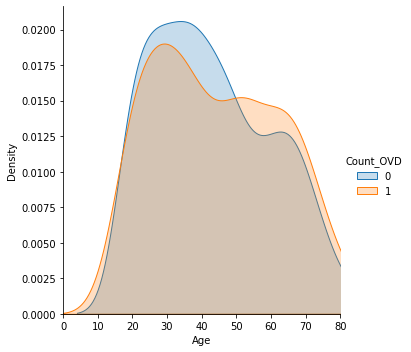

In [ ]:
(sns
 .FacetGrid(result_df,
            hue="Count_OVD",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Age",shade=True)
 .add_legend())

plt.savefig("Plots/OVD_Discrimination_Of_Age_Distribution.png")

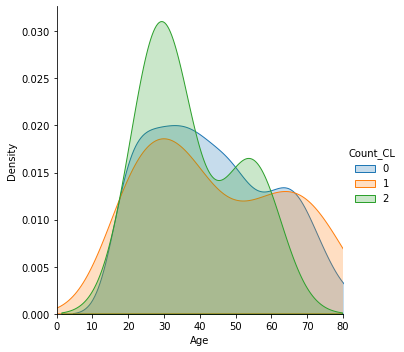

In [ ]:
(sns
 .FacetGrid(result_df,
            hue="Count_CL",
            height=5,
            xlim = (0, 80))
 .map(sns.kdeplot,"Age",shade=True)
 .add_legend())

plt.savefig("Plots/Count_CL_Discrimination_Of_Age_Distribution.png")

In [ ]:
result_df["Age"].describe().T

count    969.000000
mean      43.551084
std       17.594776
min       18.000000
25%       29.000000
50%       41.000000
75%       57.000000
max       90.000000
Name: Age, dtype: float64

# PDF Creation

In [ ]:
"""
pdf = FPDF()
pdf.set_font("Arial", "B", 56)

WIDTH = 210
HEIGHT = 297
"""

'\npdf = FPDF()\npdf.set_font("Arial", "B", 56)\n\nWIDTH = 210\nHEIGHT = 297\n'

In [ ]:
"""
pdf.add_page()

pdf.multi_cell(WIDTH, 20, txt='BANK MARKETING\nREPORT\nby TARIK CIFTCI', align='C') #ORTALAYALIM
"""

"\npdf.add_page()\n\npdf.multi_cell(WIDTH, 20, txt='BANK MARKETING\nREPORT\nby TARIK CIFTCI', align='C') #ORTALAYALIM\n"

In [ ]:
"""
pdf.add_page()
pdf.set_font("Arial", "B", 28)
pdf.multi_cell(WIDTH, 20, txt = "Sex Discrimination on Predicted Products\n (0: Male - 1: Female)", align='C')

pdf.image("Plots/Sex_Discrimination_Predicted_Sale_CC.png", 0, 30, 70)
pdf.image("Plots/Sex_Discrimination_Predicted_Sale_MF.png", 70, 30, 70)
pdf.image("Plots/Sex_Discrimination_Predicted_Sale_CL.png", 140, 30, 70)
"""

'\npdf.add_page()\npdf.set_font("Arial", "B", 28)\npdf.multi_cell(WIDTH, 20, txt = "Sex Discrimination on Predicted Products\n (0: Male - 1: Female)", align=\'C\')\n\npdf.image("Plots/Sex_Discrimination_Predicted_Sale_CC.png", 0, 30, 70)\npdf.image("Plots/Sex_Discrimination_Predicted_Sale_MF.png", 70, 30, 70)\npdf.image("Plots/Sex_Discrimination_Predicted_Sale_CL.png", 140, 30, 70)\n'

In [ ]:
"""
pdf.output("BANK_MARKETING_REPORT.pdf", "F")
"""

'\npdf.output("BANK_MARKETING_REPORT.pdf", "F")\n'

# Final step

In [ ]:
final_merged_df

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Predicted_Sale_MF,Predicted_Sale_CC,Predicted_Sale_CL,Predicted_Revenue_MF,Predicted_Revenue_CC,Predicted_Revenue_CL
0,1217,38,165,1,0,0,0,0,0,6752.244643,...,0,0.000000,0.000000,0.000000,1.0,0.0,0.0,2.980317,0.0,0.000000
1,850,49,44,1,0,0,0,0,0,43.523214,...,0,0.000000,0.893929,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,1473,54,34,1,1,0,0,1,1,29.024286,...,0,4.929643,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000
3,1038,29,106,1,0,0,0,0,0,27.035714,...,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,225,18,187,1,0,0,1,0,0,345.686071,...,1,0.000000,0.000000,8.130714,0.0,0.0,1.0,0.000000,0.0,9.240622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,37,152,1,1,0,0,0,0,1249.709643,...,0,0.000000,0.000000,0.000000,1.0,0.0,0.0,3.777615,0.0,0.000000
947,1276,28,145,1,0,0,0,0,2,13915.925357,...,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
948,384,23,160,1,0,0,0,0,0,2418.876786,...,1,0.000000,6.107143,12.506071,1.0,0.0,0.0,0.000000,0.0,0.000000
949,977,46,59,1,0,0,0,0,0,2639.308571,...,0,1.429643,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000


In [ ]:
final_d = {
    "Customer Loan (CL)": final_merged_df[final_merged_df["Predicted_Sale_CL"] == 1.0][["Age","IsFemale", "Predicted_Revenue_CL", "Predicted_Sale_CC", "Predicted_Sale_MF","Predicted_Sale_CL"]],
    "Credit Card (CC)": final_merged_df[final_merged_df["Predicted_Sale_CC"] == 1.0][["Age","IsFemale", "Predicted_Revenue_CC", "Predicted_Sale_CC", "Predicted_Sale_MF", "Predicted_Sale_CL"]],
    "Mutual Funds (MF)": final_merged_df[final_merged_df["Predicted_Sale_MF"] == 1.0][["Age","IsFemale", "Predicted_Revenue_MF", "Predicted_Sale_CC", "Predicted_Sale_MF", "Predicted_Sale_CL"]]
}

In [ ]:
final_d["Customer Loan (CL)"]

,Age,IsFemale,Predicted_Revenue_CL,Predicted_Sale_CC,Predicted_Sale_MF,Predicted_Sale_CL
2,54,0,0.000000,0.0,0.0,1.0
4,18,0,9.240622,0.0,0.0,1.0
6,18,1,7.658708,0.0,0.0,1.0
8,52,0,8.211200,0.0,0.0,1.0
10,63,1,4.663288,1.0,0.0,1.0
...,...,...,...,...,...,...
939,30,0,3.105693,1.0,0.0,1.0
940,23,1,3.129383,0.0,0.0,1.0
942,27,1,4.173448,0.0,0.0,1.0
945,56,1,0.823783,0.0,0.0,1.0


In [ ]:
product_abbrv_list = ["CC","CL","MF"]
print("We offered;\n")
for key, value in final_d.items():
  revenue_key = key.split("(")[1][:-1]
  product_abbrv_list_copy = product_abbrv_list.copy()
  product_abbrv_list_copy.remove(revenue_key)

  print(f"- {len(value)} people to get {key}")
  print(f"  - These people's age are ranged between {min(value['Age'])} - {max(value['Age'])}")
  print(f"  - {len(value[value['IsFemale'] == 1])} person was Female and {len(value[value['IsFemale'] == 0])} person was Male")
  print(f"  - {len(value.loc[value['Predicted_Sale_'+product_abbrv_list_copy[0]] == 1])} of them got {product_abbrv_list_copy[0]}")
  print(f"  - {len(value.loc[value['Predicted_Sale_'+product_abbrv_list_copy[1]] == 1])} of them got {product_abbrv_list_copy[1]}")
  print()

We offered;

- 263 people to get Customer Loan (CL)
  - These people's age are ranged between 18 - 65
  - 129 person was Female and 134 person was Male
  - 92 of them got CC
  - 46 of them got MF

- 254 people to get Credit Card (CC)
  - These people's age are ranged between 18 - 90
  - 132 person was Female and 122 person was Male
  - 92 of them got CL
  - 62 of them got MF

- 204 people to get Mutual Funds (MF)
  - These people's age are ranged between 18 - 85
  - 95 person was Female and 109 person was Male
  - 62 of them got CC
  - 46 of them got CL



In [ ]:
def sex_indicator (row):
  if row['IsFemale'] == 1 :
    return "Female"
  else:
    return "Male"

In [ ]:
for key, value in final_d.items():
  value["Sex"] = value.apply(lambda x: sex_indicator(x), axis = 1)


# We'll visualize the results in the form of a plot



Customer Loan (CL) Sex Distribution


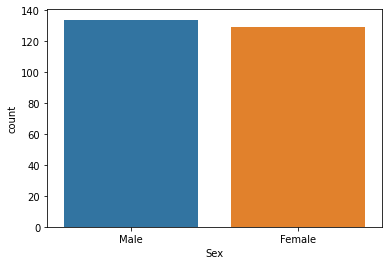


Credit Card (CC) Sex Distribution


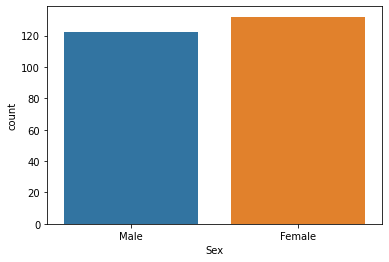


Mutual Funds (MF) Sex Distribution


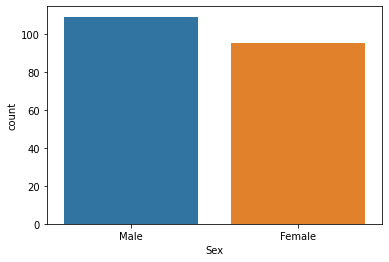

In [ ]:
for key, value in final_d.items():
  print(f"{key} Sex Distribution")

  sns.countplot(x = value["Sex"])
  #plt.legend(title='Sex', loc='upper left', labels=["Male","Female"])
  
  plt.show()
  print()

Customer Loan (CL) Age Distribution


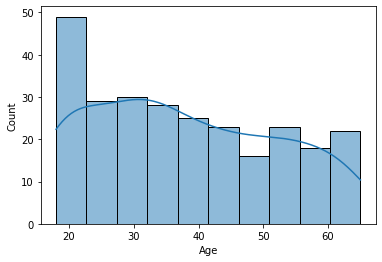


Credit Card (CC) Age Distribution


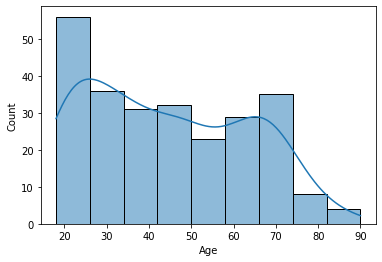


Mutual Funds (MF) Age Distribution


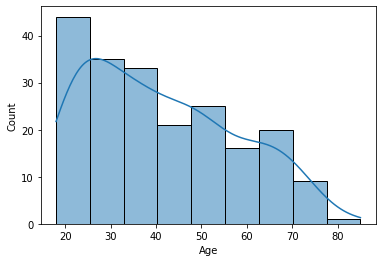

In [ ]:
for key, value in final_d.items():
  print(f"{key} Age Distribution")
  sns.histplot(x = value["Age"],kde=True)
  #plt.legend(title='Sex', loc='upper left', labels=["Male","Female"])
  
  plt.show()
  print()

Age - Customer Loan (CL) Distribution


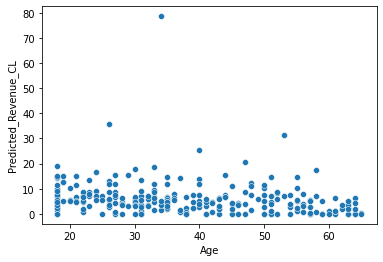


Age - Credit Card (CC) Distribution


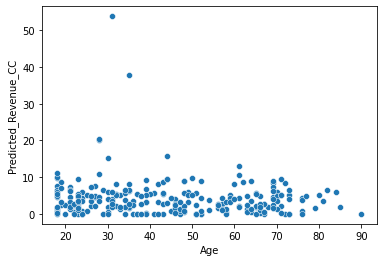


Age - Mutual Funds (MF) Distribution


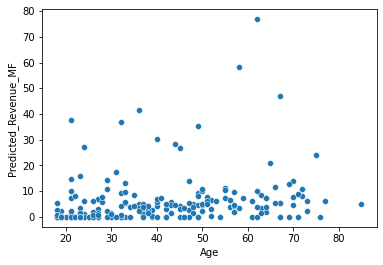

In [ ]:
for key, value in final_d.items():
  revenue_key = key.split("(")[1][:-1]
  
  print(f"Age - {key} Distribution")
  sns.scatterplot(x = value["Age"], y = value["Predicted_Revenue_"+revenue_key])
  
  plt.show()
  print()

To conclude, we can say that despite all the analytical work, it is necessary to have better quality data because we lack a lot of it. 

The accuracy, the F1 score are far too insignificant to be able to predict reliable and efficient results for the company. Beyond the socre, it is the business analysis that will be fundamental because from one sector to another, a low accuracy or f1 score can be accepted by the client if it meets its requirement criteria. 

Even though a trend is emerging, where age plays an important role in product attribution, i.e. the older the customer, the less they will be offered the desired product.